In [1]:
from flask import Flask, render_template, request, json, jsonify

import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

import tweepy
import time

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta

import base64

app = Flask(__name__)
app.config['JSON_AS_ASCII'] = False

@app.route("/index", methods=['GET', 'POST'])
def index():
    if request.method == 'GET':
        return render_template('index.html')
    if request.method == 'POST':
        id = request.form.get('id')
        data_tuple = find_relationship(id)
        return render_template('test.html', data=users_name_url)

@app.route("/detail")
def detail():
    ti7d = get_user_image()
    uae = get_user_all_engagement(ti7d)
    ic = open("templates/icon.json", "r",  encoding="utf-8")
    icon = json.load(ic)
    ic.close()
    img_stream = []
    for i in range(15):
        image_path1 = "./image/" + str(i) + ".png"  
        image_path2 = "./image/" + str(i) + "c.png"  #前端要這樣用 ex:<img src="data:;base64,{{ img1 }}">
        img_stream.append([return_img_stream(image_path1), return_img_stream(image_path2)])
    return render_template('tttt.html', data=uae, icon=icon, img0=img_stream[0][0], img0c=img_stream[0][1], img1=img_stream[1][0], img1c=img_stream[1][1], img2=img_stream[2][0], img2c=img_stream[2][1], img3=img_stream[3][0], img3c=img_stream[3][1], img4=img_stream[4][0], img4c=img_stream[4][1], img5=img_stream[5][0], img5c=img_stream[5][1], img6=img_stream[6][0], img6c=img_stream[6][1], img7=img_stream[7][0], img7c=img_stream[7][1], img8=img_stream[8][0], img8c=img_stream[8][1], img9=img_stream[9][0], img9c=img_stream[9][1], img10=img_stream[10][0], img10c=img_stream[10][1], img11=img_stream[11][0], img11c=img_stream[11][1], img12=img_stream[12][0], img12c=img_stream[12][1], img13=img_stream[13][0], img13c=img_stream[13][1], img14=img_stream[14][0], img14c=img_stream[14][1])


#config
API_KEY = 'M16MB2eCRRvWCcfKDvr0qkxx5'
API_SECRET = 'UEt06p8FCjWOdOa784wiXgp0k9XspBOuMMrL50KSvv9YYQoPeP'
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAOtVZAEAAAAAiG%2BIch2KP0AYd6MvmzDeCrjOO9s%3DxtpORldSCmg3V9TXGTZjhevpJHmqS5MhNM4FDG23ZIllelYJbu'
ACCESS_TOKEN = '1477449401719455745-j18PMElaCaxr2ZgPDx3xVMGuaULrdn'
ACCESS_TOKEN_SECRET = '8JR9KBNpQAUkH5HxnvnZxHhPCZC97oaAXbf6ihQ0Fk88M'

client = tweepy.Client(bearer_token = BEARER_TOKEN)

users_name_url = {"twitter":[]}

model = torch.load('model3.pth',map_location ='cpu')
token = BertTokenizer.from_pretrained('bert-base-chinese')

def find_relationship(id):
    ids = [id]
    #get user_id
    users = client.get_users(usernames=id, user_fields = ['profile_image_url'])
    user_main = {}
    for user in users.data:
        USER_ID = user.id
        USER_NAME = user.name
        USER_URL = user.profile_image_url
        USER_USERNAME = user.username

    #get user tweet_id
    tweet_id = []
    t = client.get_users_tweets(id = USER_ID, max_results = 50, tweet_fields = ['conversation_id', 'in_reply_to_user_id'])
    for i in t.data:
        tweet_id.append(i.id)

    #get user followers_id
    followers_id = []  
    tmp = []
    for response in tweepy.Paginator(client.get_users_followers, USER_ID, max_results=1000, limit=2):
        for i in response:
            tmp.append(i)
    for i in range(0, len(tmp), 4):
        for j in range(len(tmp[i])):
            followers_id.append(tmp[i][j].id)

    #get user following_id
    following_id = []
    tmp = []
    for response in tweepy.Paginator(client.get_users_following, USER_ID, max_results=1000, limit=2):
        for i in response:
            tmp.append(i)
    for i in range(0, len(tmp), 4):
        for j in range(len(tmp[i])):
            following_id.append(tmp[i][j].id)

    #get tweets reply_user
    reply_user = []
    for k in range(len(tweet_id)):
        query = 'conversation_id:' + str(tweet_id[k])
        l = client.search_recent_tweets(query = query, max_results = 50, expansions = ['author_id'])
        try:
            for i in l.data:
                reply_user.append(i.author_id)
        except:
            print("", end = "")
    
    #get tweets liking_users
    liking_users = []
    for k in range(len(tweet_id)):
        try:
            l = client.get_liking_users(id = tweet_id[k])
        except:
            print("sleep")
            time.sleep(60)
        try:
            for i in l.data:
                liking_users.append(i.id)
        except:
            print("", end = "")
    
    #get tweets retweeters
    retweeters = []
    for k in range(len(tweet_id)):
        try:
            l = client.get_retweeters(id = tweet_id[k])
        except:
            print("sleep")
            time.sleep(60)
        try:
            for i in l.data:
                retweeters.append(i.id)
        except:
            print("", end = "")
    

    #count relationship
    total = {}
    for i in liking_users:
        if i in total.keys():
            total[i] += 2
        else:
            total[i] = 2

    for i in retweeters:
        if(i in total.keys()):
            total[i] += 2
        else:
            total[i] = 2

    for i in reply_user:
        if i in total.keys():
            total[i] += 3
        else:
            total[i] = 3
    
    total[USER_ID] = 0
    
    result = sorted(total.items(), key=lambda x:x[1])[-14:]

    result_rev = []
    for i in range(len(result)-1, -1, -1):
        result_rev.append(result[i])
    
    #top 10 user_data
    related_id = {}
    user_name = {}
    for i in result:
        u = client.get_users(ids = i[0], user_fields = ['profile_image_url'])
        for k in u.data:
            related_id[k.id] = []
            user_name[k.id] = k.name
            users_name_url["twitter"].append({"id":str(k.id), "name":k.name, "username":k.username, "url":k.profile_image_url})
    users_name_url["twitter"].append({"id":str(USER_ID), "name":USER_NAME, "username":USER_USERNAME, "url":USER_URL})
    for i in range(len(users_name_url['twitter'])):
        users_name_url['twitter'][i]['url'] = users_name_url['twitter'][i]['url'].replace("normal.jpg", "400x400.jpg")
    return users_name_url


def get_user_image():
    import matplotlib.pyplot as plt
    import pandas as pd
    import plotly.express as px
    from datetime import datetime, timedelta

    dtformat = '%Y-%m-%dT%H:%M:%SZ'
    times = datetime.now()
    start_time = times - timedelta(days=7)
    start_time, end_time = start_time.strftime(dtformat), time.strftime(dtformat)

    tweets_id_7days = []

    for k in range(len(users_name_url['twitter'])):
        tmp = []
        tweets_7days = []
        idss = int(users_name_url['twitter'][k]['id'])
        print(idss)
        for response in tweepy.Paginator(client.get_users_tweets, id = idss, max_results=100, start_time = start_time, end_time = end_time, tweet_fields = ["referenced_tweets", "created_at"], limit=10):
            for i in response:
                tmp.append(i)
        if tmp[0] != None:
            for i in range(0, len(tmp), 4):
                tmpp = []
                for j in range(len(tmp[i])):
                    tweets_7days.append({"id":users_name_url['twitter'][k]['id'], "text":tmp[i][j].text, "time":tmp[i][j].created_at})
                    if(k == len(users_name_url['twitter'])-1):
                        tweets_id_7days.append(tmp[i][j].id)
                    
            for i in range(len(tweets_7days)):
                tweets_7days[i]["text"] = denoise_text(tweets_7days[i]["text"])
                text = tweets_7days[i]["text"]
                """try:
                    tweets_7days[i]["text"] = translator.translate(text, dest='zh-tw').text
                except:
                    print(end = "")"""

            for j in range(len(tweets_7days)):
                test_dataset = Dataset([tweets_7days[j]["text"]], [-1])
                testloader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_fn)
                for i in testloader:
                    tokens_tensors, segments_tensors, masks_tensors = i[:3]
                    outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors)
                    logits = outputs[0]
                    labels = i[3]
                    _, pred = torch.max(logits.data, 1)
                    if pred[0] == 0:
                        tweets_7days[j]["sentiment"] = 0
                    elif pred[0] == 1:
                        tweets_7days[j]["sentiment"] = 1
                    elif pred[0] == 2:
                        tweets_7days[j]["sentiment"] = 2
                    elif pred[0] == 3:
                        tweets_7days[j]["sentiment"] = 3
                        
            sentiment_0 = {}
            sentiment_1 = {}
            sentiment_2 = {}
            sentiment_3 = {}
            plt_day = []
            plt_day_2 = []
            
            for i in range(8):
                tt = times - timedelta(days=i)
                sentiment_0[tt.day] = 0
                sentiment_1[tt.day] = 0
                sentiment_2[tt.day] = 0
                sentiment_3[tt.day] = 0
                plt_day.append(tt.day)
                plt_day_2.append(str(tt.month) + "/" + str(tt.day))

            for i in range(len(tweets_7days)):
                if tweets_7days[i]['sentiment'] == 0:
                        sentiment_0[tweets_7days[i]['time'].day] += 1
                elif tweets_7days[i]['sentiment'] == 1:
                        sentiment_1[tweets_7days[i]['time'].day] += 1
                elif tweets_7days[i]['sentiment'] == 2:
                        sentiment_2[tweets_7days[i]['time'].day] += 1
                elif tweets_7days[i]['sentiment'] == 3:
                        sentiment_3[tweets_7days[i]['time'].day] += 1

            plt_sentiment_0 = []
            plt_sentiment_1 = []
            plt_sentiment_2 = []
            plt_sentiment_3 = []
            
            plt_day.reverse()
            plt_day_2.reverse()
            
            for i in plt_day:
                plt_sentiment_0.append(sentiment_0[i])
                plt_sentiment_1.append(sentiment_1[i])
                plt_sentiment_2.append(sentiment_2[i])
                plt_sentiment_3.append(sentiment_3[i])

            plt.figure(figsize=(10,5),dpi=100,linewidth = 2)
            tryy = [0,1,2,3,4,5,6,7]
            plt.plot(tryy,plt_sentiment_0,'o-',color = 'r', label="happy")
            plt.plot(tryy,plt_sentiment_1,'o-',color = 'g', label="angry")
            plt.plot(tryy,plt_sentiment_2,'o-',color = 'b', label="sorrow")
            plt.plot(tryy,plt_sentiment_3,'o-',color = 'k', label="normal")
            plt.title("", x=0.5, y=1.03)
            
            plt.xticks(tryy, plt_day_2, fontsize=20)
            plt.yticks(fontsize=20)

            plt.xlabel("date", fontsize=15, labelpad = 15)
            plt.ylabel("count", fontsize=15, labelpad = 20)
            plt.legend(loc = "best", fontsize=10)

            plt.savefig('./image/'+ str(k) +'.png', dpi=300, bbox_inches='tight')
            plt.show()
            plt.clf()

            df = pd.DataFrame([['happy', sum(plt_sentiment_0)], 
                            ['angry', sum(plt_sentiment_1)], 
                            ['sorrow', sum(plt_sentiment_2)], 
                            ['normal', sum(plt_sentiment_3)]], 
                            columns=['sentiment', 'count'])

            fig = px.pie(df, values='count', names='sentiment', title='')
            fig.update_traces(textposition='inside', textinfo='percent+label', insidetextorientation='radial')
            fig.write_image('./image/'+str(k)+"c.png")
            fig.show()
    
    return tweets_id_7days 

def get_user_all_engagement(tweets_id_7days):
    reply_user = []
    for k in range(len(tweets_id_7days)):
        query = 'conversation_id:' + str(tweets_id_7days[k])
        l = client.search_recent_tweets(query=query, max_results = 100, expansions = ['author_id'])
        try:
            for i in l.data:
                reply_user.append(i.author_id)
        except:
            print("", end = "")

    liking_users = []
    for k in range(len(tweets_id_7days)):
        try:
            l = client.get_liking_users(id = tweets_id_7days[k])
        except:
            print("sleep")
            time.sleep(360)
        try:
            for i in l.data:
                liking_users.append(i.id)
        except:
            print("", end = "")

    retweeters = []
    for k in range(len(tweets_id_7days)):
        try:   
            l = client.get_retweeters(id = tweets_id_7days[k])
        except:
            print("sleep")
            time.sleep(360)
        try:
            for i in l.data:
                retweeters.append(i.id)
        except:
            print("", end = "")


    user_all_Engagement = {"twitter":[]}
    a = []
    for i in range(len(users_name_url['twitter'])):
        a.append(int(users_name_url['twitter'][i]['id']))
        user_all_Engagement['twitter'].append({"id":users_name_url['twitter'][i]['id']})

    for i in liking_users:
        if i in a:
            for k in range(len(user_all_Engagement['twitter'])):
                if int(user_all_Engagement['twitter'][k]['id']) == i:
                    if "liking" not in user_all_Engagement['twitter'][k].keys():
                        user_all_Engagement['twitter'][k]['liking'] = 0
                    elif "liking" in user_all_Engagement['twitter'][k].keys():
                        user_all_Engagement['twitter'][k]['liking'] += 1

    for i in retweeters:
        if i in a:
            for k in range(len(user_all_Engagement['twitter'])):
                if int(user_all_Engagement['twitter'][k]['id']) == i:
                    if "retweet" not in user_all_Engagement['twitter'][k].keys():
                        user_all_Engagement['twitter'][k]['retweet'] = 0
                    elif "retweet" in user_all_Engagement['twitter'][k].keys():
                        user_all_Engagement['twitter'][k]['retweet'] += 1
    for i in reply_user:
        if i in a:
            for k in range(len(user_all_Engagement['twitter'])):
                if int(user_all_Engagement['twitter'][k]['id']) == i:
                    if "reply" not in user_all_Engagement['twitter'][k].keys():
                        user_all_Engagement['twitter'][k]['reply'] = 0
                    elif "reply" in user_all_Engagement['twitter'][k].keys():
                        user_all_Engagement['twitter'][k]['reply'] += 1
    for i in range(len(user_all_Engagement['twitter'])):
        if "liking" not in user_all_Engagement['twitter'][i].keys():
            user_all_Engagement['twitter'][i]['liking'] = 0
        if "retweet" not in user_all_Engagement['twitter'][i].keys():
            user_all_Engagement['twitter'][i]['retweet'] = 0
        if "reply" not in user_all_Engagement['twitter'][i].keys():
            user_all_Engagement['twitter'][i]['reply'] = 0

    return user_all_Engagement


import re
from bs4 import BeautifulSoup

from googletrans import Translator
translator = Translator()

#Removeing @...
def remove_pattern(text):
    return re.sub('@[\w]*', '', text)

#Removeing http
def remove_http(text):
    results = re.compile(r'[http|https]*://[a-zA-Z0-9._?/&=:]*', re.S) 
    return re.sub(results, '', text)

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Removing the noisy text
def denoise_text(text):
    text = remove_pattern(text)
    text = remove_http(text)
    return text

class Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

def collate_fn(data):
    sents = [data[i][0] for i in range(len(data))]
    labels = [data[i][1] for i in range(len(data))]
    
    data = token.batch_encode_plus(batch_text_or_text_pairs=sents,
                    truncation=True, 
                    padding='max_length',
                    max_length=50,
                    return_tensors='pt',
                    return_length=True)
    
    input_ids = data['input_ids'] 
    attention_mask = data['attention_mask'] 
    token_type_ids = data['token_type_ids'] 
    labels = torch.LongTensor(labels) 
    
    return input_ids, attention_mask, token_type_ids, labels

def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    tmp = []
    with torch.no_grad():
        for data in dataloader:
            
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            tmp.append(pred[0])
    return tmp

import re
from bs4 import BeautifulSoup

from googletrans import Translator
translator = Translator()

#Removeing @...
def remove_pattern(text):
    return re.sub('@[\w]*', '', text)

#Removeing http
def remove_http(text):
    results = re.compile(r'[http|https]*://[a-zA-Z0-9._?/&=:]*', re.S) 
    return re.sub(results, '', text)

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Removing the noisy text
def denoise_text(text):
    text = remove_pattern(text)
    text = remove_http(text)
    return text

class Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

def collate_fn(data):
    sents = [data[i][0] for i in range(len(data))]
    labels = [data[i][1] for i in range(len(data))]
    
    data = token.batch_encode_plus(batch_text_or_text_pairs=sents,
                    truncation=True, 
                    padding='max_length',
                    max_length=50,
                    return_tensors='pt',
                    return_length=True)
    
    input_ids = data['input_ids'] 
    attention_mask = data['attention_mask'] 
    token_type_ids = data['token_type_ids'] 
    labels = torch.LongTensor(labels) 
    
    return input_ids, attention_mask, token_type_ids, labels

def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    tmp = []
    with torch.no_grad():
        for data in dataloader:
            
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            tmp.append(pred[0])
    return tmp


def return_img_stream(img_local_path):
    img_stream = ''
    with open(img_local_path, 'rb') as img_f:
        img_stream = img_f.read()
        img_stream = base64.b64encode(img_stream).decode()
    return img_stream


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [08/Sep/2022 14:34:05] "GET /index HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2022 14:34:05] "GET /static/index_setting.css HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2022 14:34:05] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [08/Sep/2022 14:34:43] "POST /index HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2022 14:34:43] "GET /static/concertric.css HTTP/1.1" 200 -


122662798


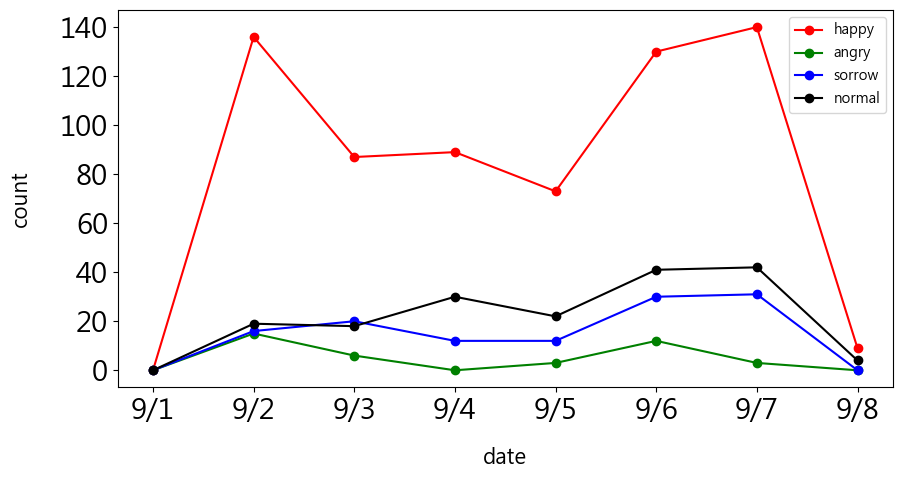

1417083492911882240


<Figure size 432x288 with 0 Axes>

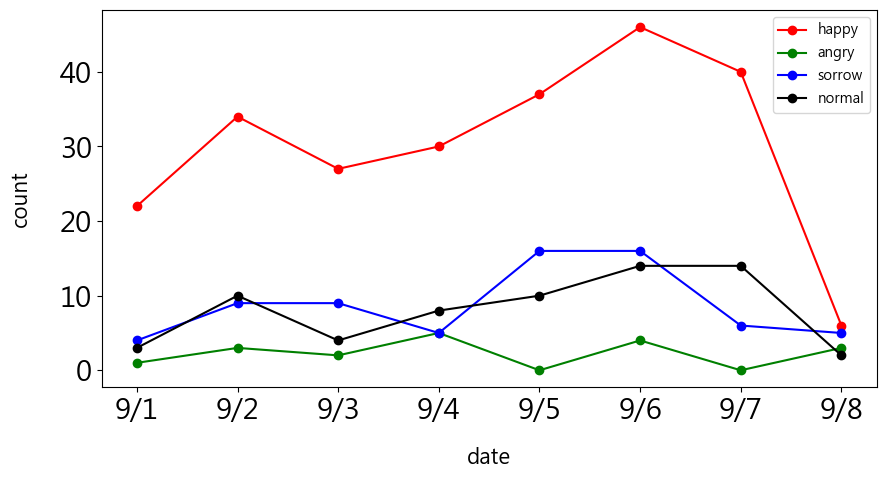

1110047127525195777


<Figure size 432x288 with 0 Axes>

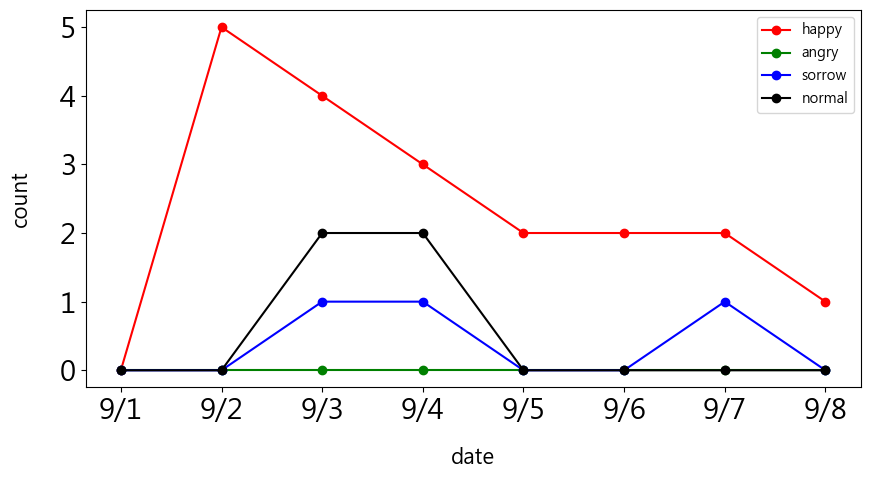

1411184992269438976


<Figure size 432x288 with 0 Axes>

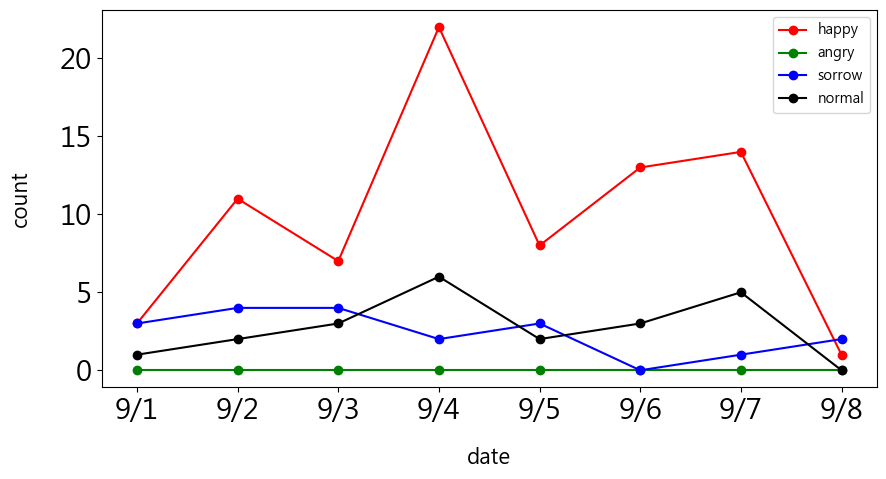

1146659565309554689


<Figure size 432x288 with 0 Axes>

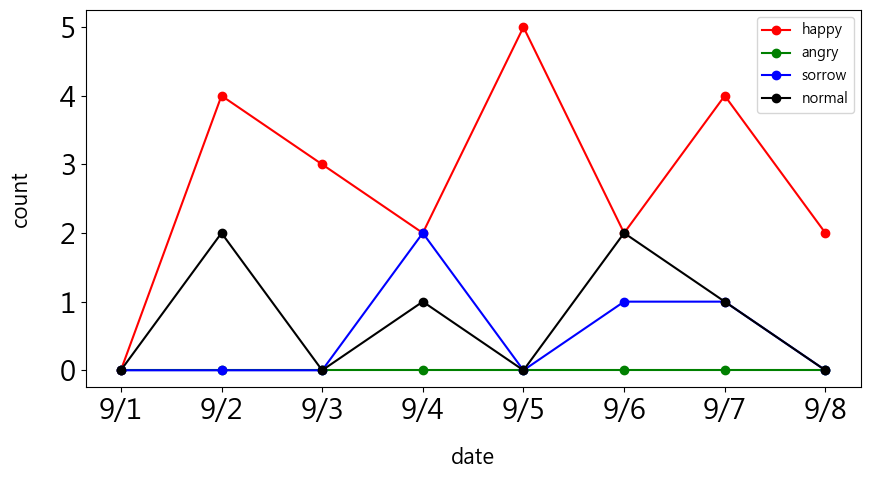

1352904377304932352


<Figure size 432x288 with 0 Axes>

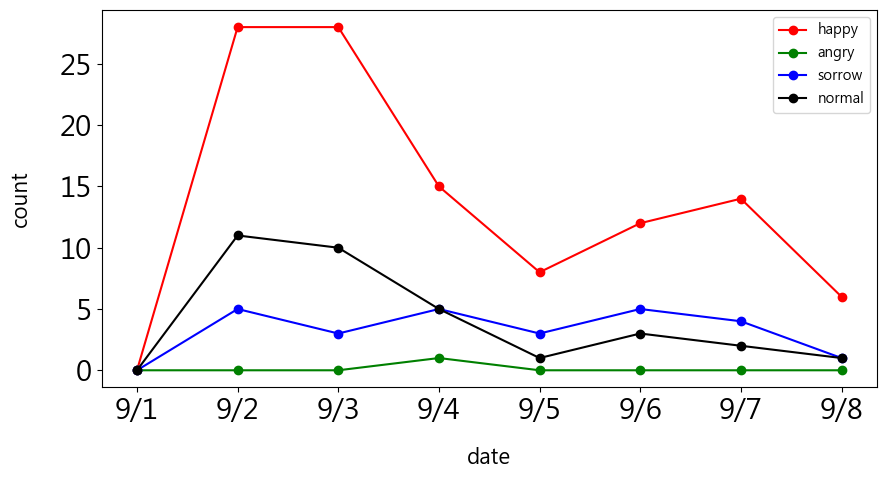

982126618603765760


<Figure size 432x288 with 0 Axes>

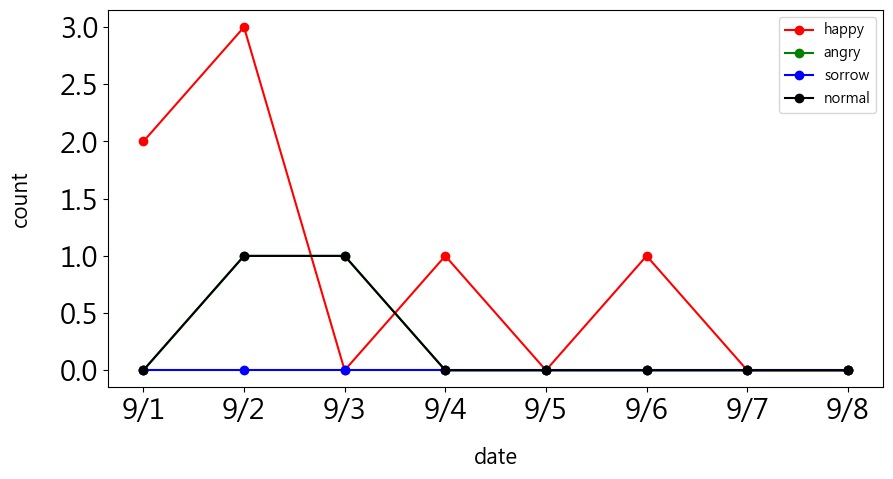

1040076874813034496


<Figure size 432x288 with 0 Axes>

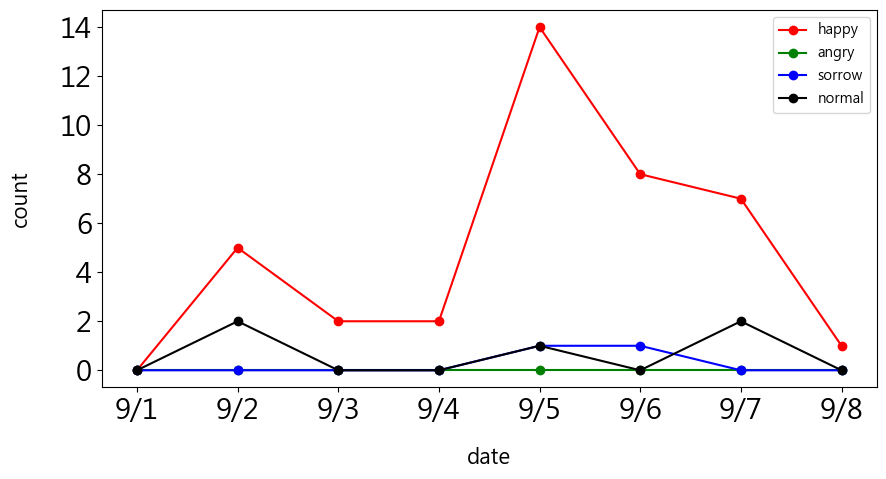

1913124810


<Figure size 432x288 with 0 Axes>

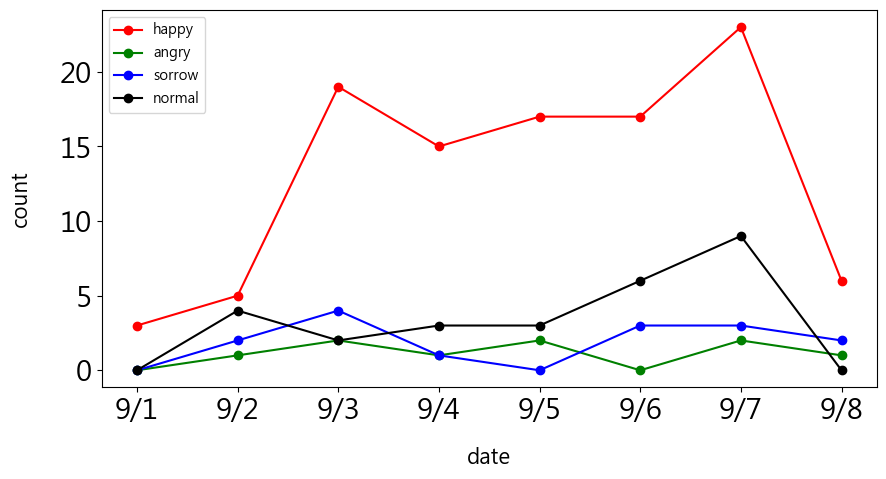

4073738354


<Figure size 432x288 with 0 Axes>

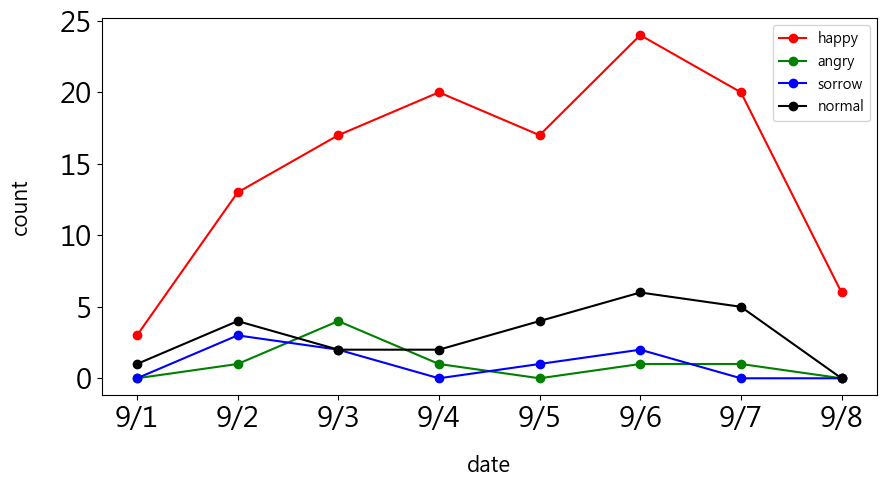

343389559


<Figure size 432x288 with 0 Axes>

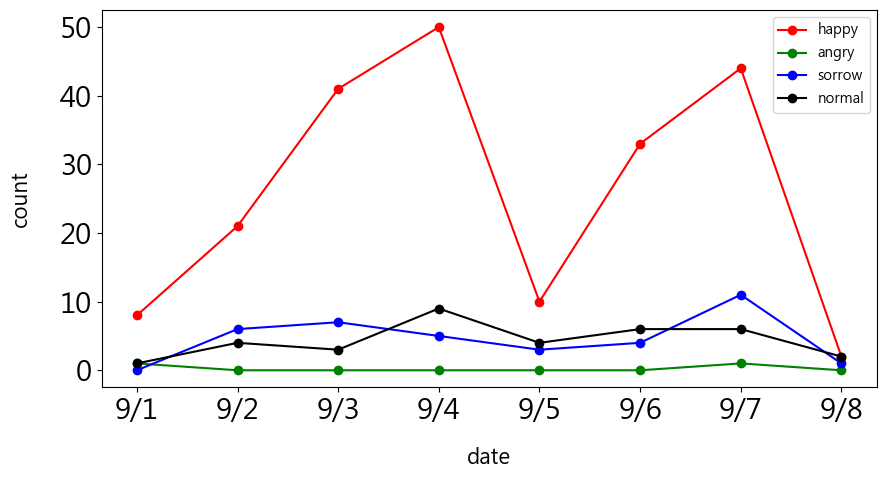

2409761143


<Figure size 432x288 with 0 Axes>

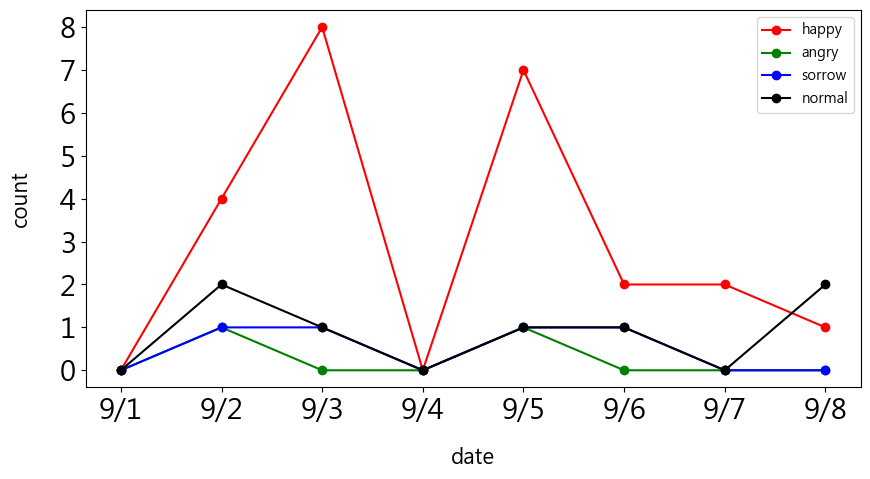

1147488640928325633


<Figure size 432x288 with 0 Axes>

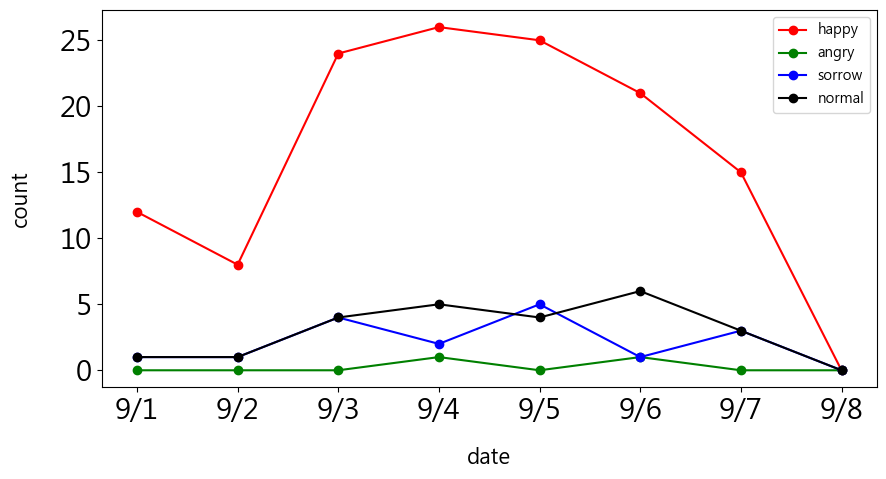

73857133


<Figure size 432x288 with 0 Axes>

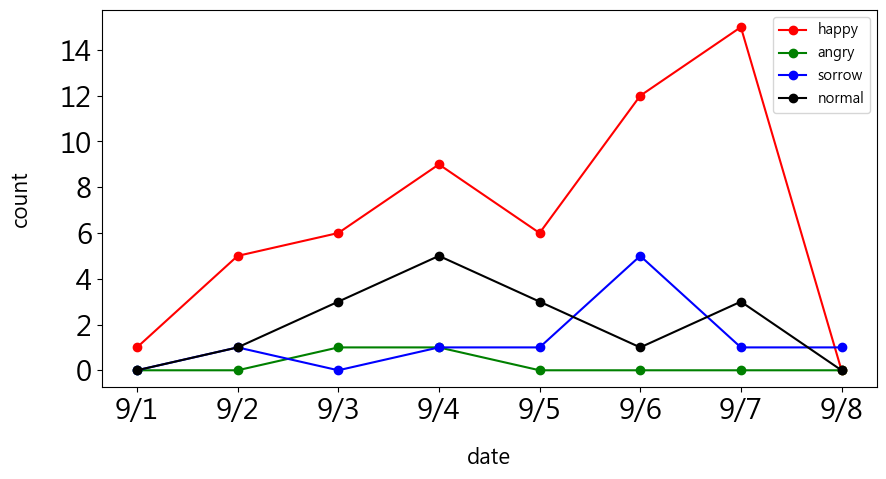

1107986872892944385


<Figure size 432x288 with 0 Axes>

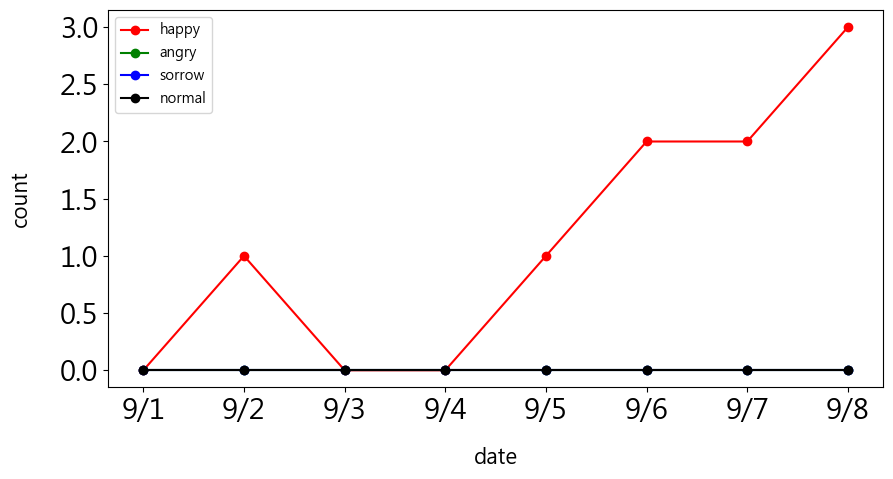

127.0.0.1 - - [08/Sep/2022 14:38:12] "GET /detail HTTP/1.1" 200 -


<Figure size 432x288 with 0 Axes>

In [2]:
app.run()